In [41]:
# Imports
import os
import sqlite3
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set random seed for reproducibility
np.random.seed(42)

# Visualization settings
sns.set(style='whitegrid')
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Database path
db_path = '../safe-haven-detection.db'

# Establish a connection to the database
conn = sqlite3.connect(db_path)

# Define the SQL query
query = """
SELECT
    uc.fips_code,
    uc.state_name,
    uc.county_name,
    c.crime_rate_per_100000,
    c.murder,
    c.rape,
    c.robbery,
    c.burglary,
    p.poverty_percentage,
    p.poverty_percentage_under_18,
    p.poverty_percentage_5_17,
    u.unemployment_rate_2022,
    u.unemployment_rate_2021,
    e.pct_no_hs_degree_18_22,
    e.pct_no_hs_degree_2000,
    pop.population_estimate_2022
FROM us_counties uc
JOIN crime c ON uc.fips_code = c.fips_code
JOIN poverty p ON uc.fips_code = p.fips_code
JOIN unemployment u ON uc.fips_code = u.fips_code
JOIN education e ON uc.fips_code = e.fips_code
JOIN population pop ON uc.fips_code = pop.fips_code;
"""

# Execute the query and load the result into a DataFrame
data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# EDA

In [43]:
data.head()

,fips_code,state_name,county_name,crime_rate_per_100000,murder,rape,robbery,burglary,poverty_percentage,poverty_percentage_under_18,poverty_percentage_5_17,unemployment_rate_2022,unemployment_rate_2021,pct_no_hs_degree_18_22,pct_no_hs_degree_2000,population_estimate_2022
0,29510,Missouri,St. Louis,1791.995377,119,200,1778,4995,21.5,33.0,34.3,3.1,5.9,24.677692,27.5,286193
1,48261,Texas,Kenedy,1456.310680,0,3,1,5,14.2,23.4,18.9,6.1,5.9,21.839080,21.8,354
2,24510,Maryland,Baltimore,1419.537569,216,317,3638,7804,22.9,33.8,32.1,4.3,7.0,28.165550,28.2,569107
3,47157,Tennessee,Shelby,1315.003752,135,483,3512,14011,18.0,23.9,23.0,4.5,7.0,27.584090,26.2,916357
4,29201,Missouri,Scott,1163.145839,2,7,26,236,15.9,23.1,22.3,2.4,3.7,38.294074,42.7,37868


In [44]:
data.describe()

,fips_code,crime_rate_per_100000,murder,rape,robbery,burglary,poverty_percentage,poverty_percentage_under_18,poverty_percentage_5_17,unemployment_rate_2022,unemployment_rate_2021,pct_no_hs_degree_18_22,pct_no_hs_degree_2000,population_estimate_2022
count,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1262.000000,1.265000e+03
mean,30057.518577,225.891148,3.807115,20.747826,75.504348,514.514625,15.163399,21.028458,19.853043,3.597866,4.625296,34.648886,34.953803,8.338917e+04
std,15383.482974,195.677851,21.063101,67.128635,518.831498,1918.919674,5.735481,8.559807,8.283963,1.200944,1.703735,7.195466,6.382302,2.622761e+05
min,1101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.600000,3.600000,2.900000,0.600000,0.900000,7.125206,12.600000,4.400000e+01
25%,18143.000000,89.232600,0.000000,1.000000,0.000000,35.000000,11.200000,14.700000,13.700000,2.800000,3.500000,30.078247,31.000000,1.000900e+04
50%,29109.000000,179.246714,0.000000,4.000000,3.000000,113.000000,14.300000,20.300000,19.000000,3.400000,4.400000,34.897049,35.100000,2.245300e+04
75%,47185.000000,315.699535,2.000000,15.000000,17.000000,321.000000,18.200000,26.100000,24.800000,4.200000,5.400000,39.796890,39.100000,5.856700e+04
max,55141.000000,1791.995377,433.000000,1143.000000,12449.000000,43644.000000,40.500000,58.500000,61.100000,12.500000,15.600000,53.071429,52.500000,4.781337e+06


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fips_code                    1265 non-null   int64  
 1   state_name                   1265 non-null   object 
 2   county_name                  1265 non-null   object 
 3   crime_rate_per_100000        1265 non-null   float64
 4   murder                       1265 non-null   int64  
 5   rape                         1265 non-null   int64  
 6   robbery                      1265 non-null   int64  
 7   burglary                     1265 non-null   int64  
 8   poverty_percentage           1265 non-null   float64
 9   poverty_percentage_under_18  1265 non-null   float64
 10  poverty_percentage_5_17      1265 non-null   float64
 11  unemployment_rate_2022       1265 non-null   float64
 12  unemployment_rate_2021       1265 non-null   float64
 13  pct_no_hs_degree_1

#### Missing Values Analysis

In [46]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

fips_code                      0
state_name                     0
county_name                    0
crime_rate_per_100000          0
murder                         0
rape                           0
robbery                        0
burglary                       0
poverty_percentage             0
poverty_percentage_under_18    0
poverty_percentage_5_17        0
unemployment_rate_2022         0
unemployment_rate_2021         0
pct_no_hs_degree_18_22         0
pct_no_hs_degree_2000          3
population_estimate_2022       0
dtype: int64


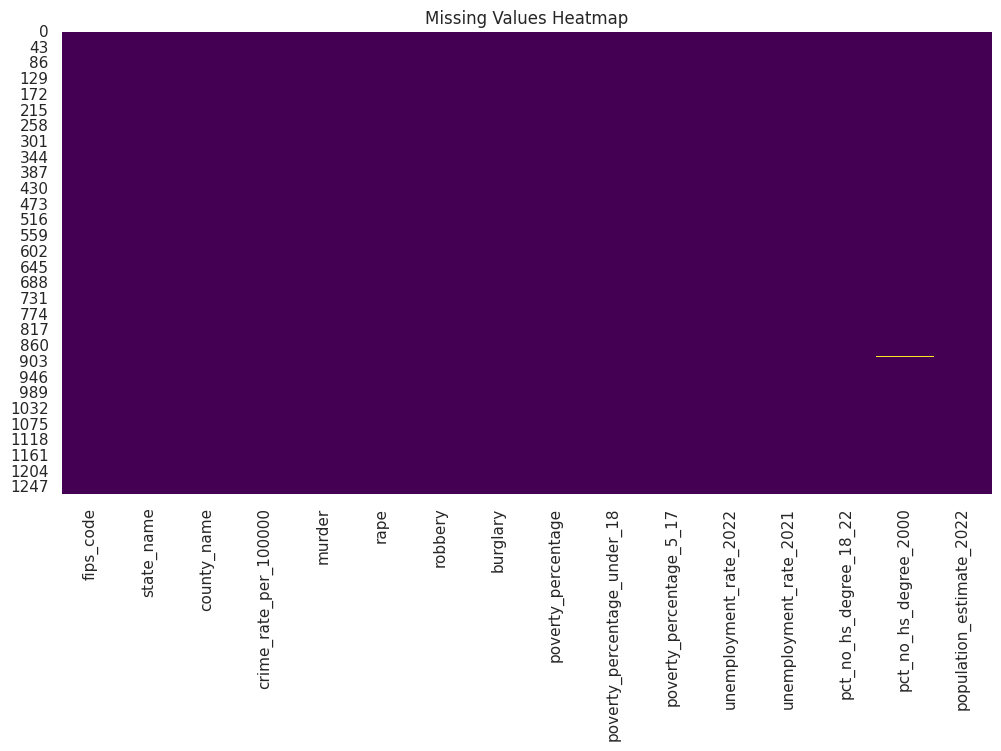

In [47]:
# Visualize missing values
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

#### Feature Distribution Analysis

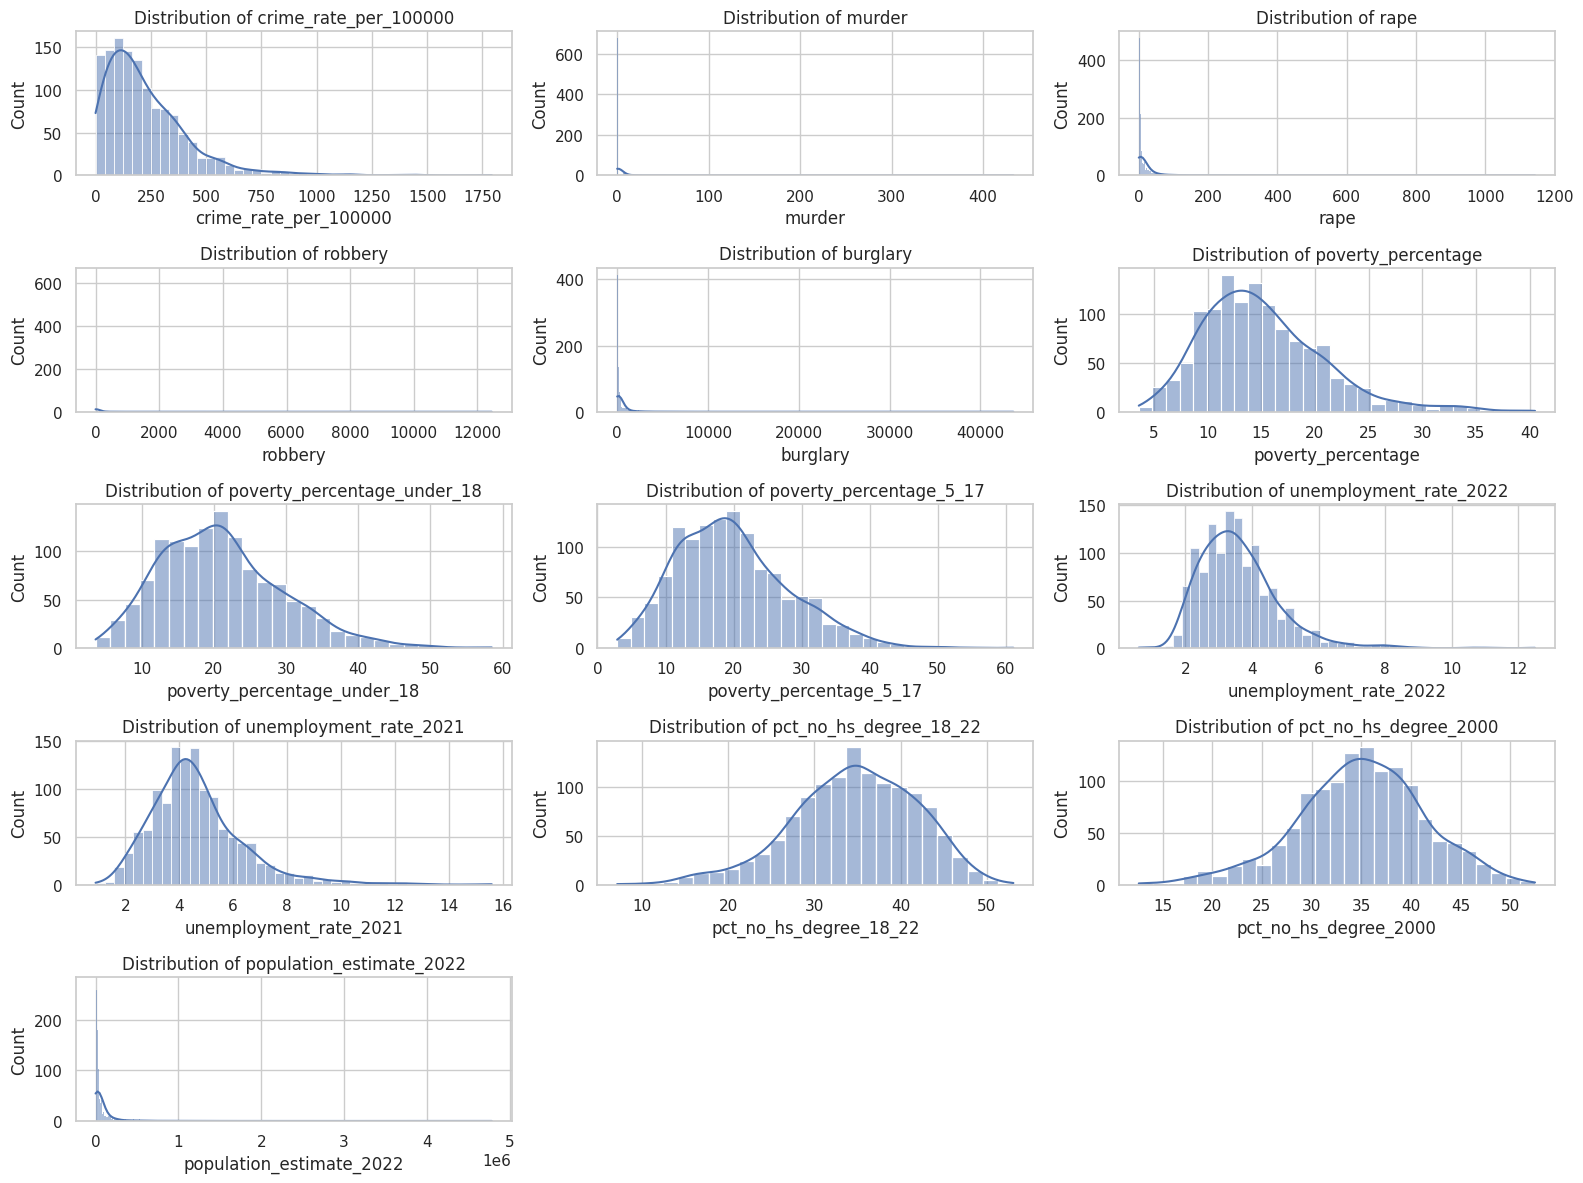

In [48]:
# List of features for distribution plots
features = ['crime_rate_per_100000', 'murder', 'rape', 'robbery', 'burglary',
            'poverty_percentage', 'poverty_percentage_under_18', 'poverty_percentage_5_17',
            'unemployment_rate_2022', 'unemployment_rate_2021',
            'pct_no_hs_degree_18_22', 'pct_no_hs_degree_2000', 'population_estimate_2022']

# Function to plot distributions
def plot_distributions(data, features, n_rows, n_cols):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
    axes = axes.flatten()
    for i, feature in enumerate(features):
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

# Plot distributions
plot_distributions(data, features, n_rows=5, n_cols=3)

#### Correlation Analysis

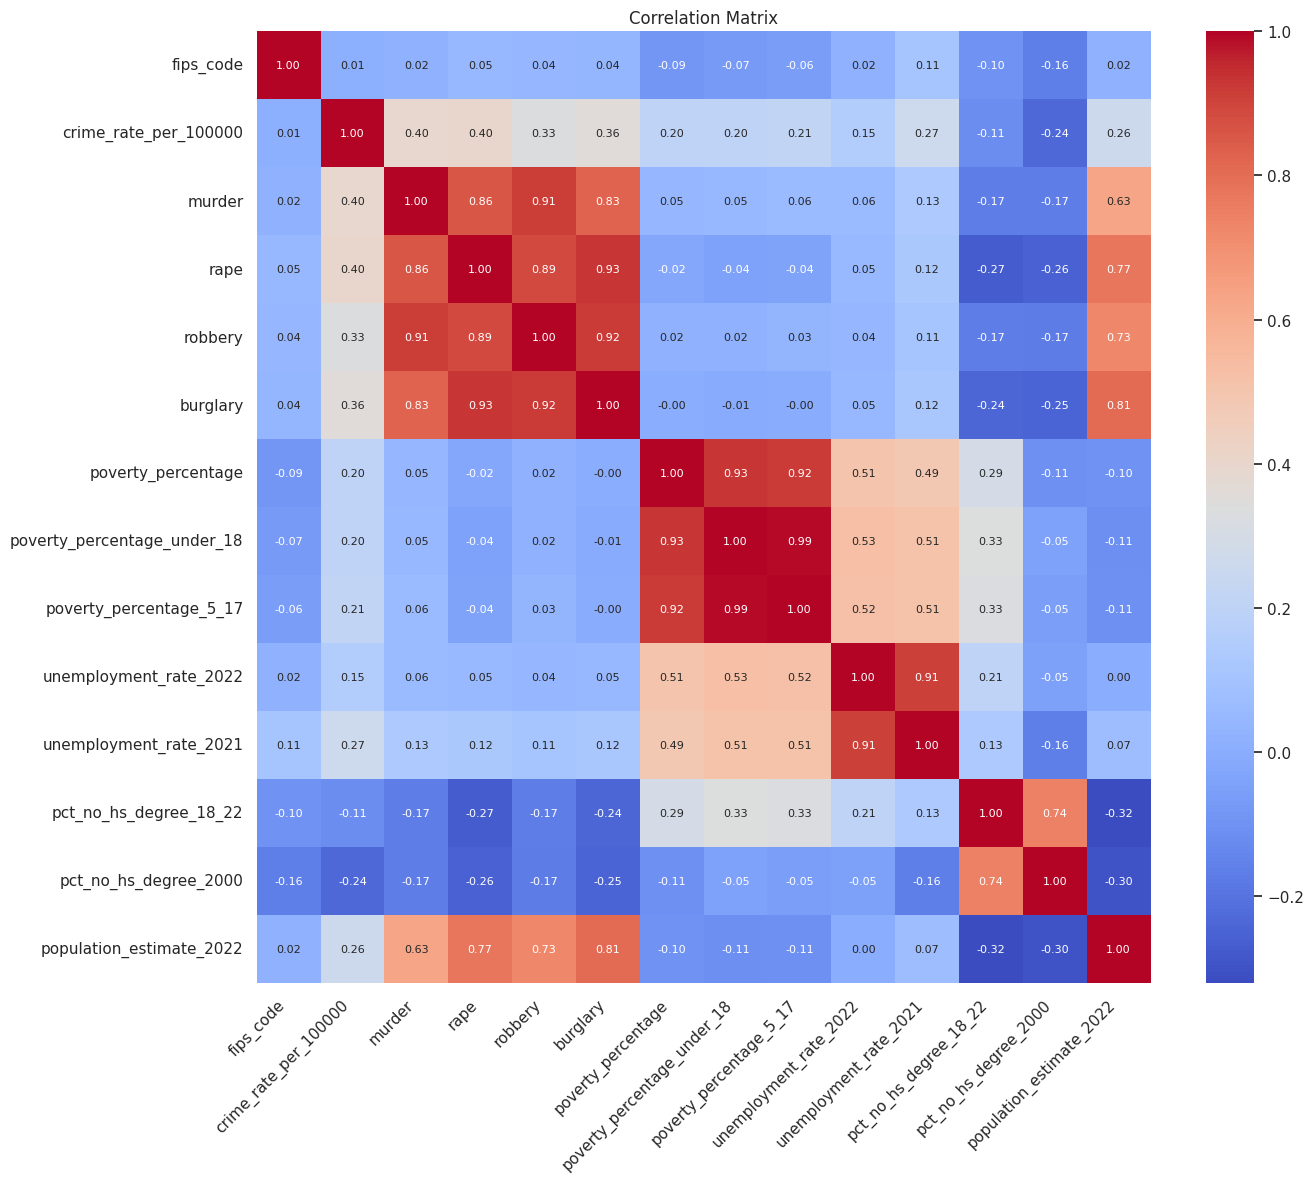

In [49]:
# Select numerical columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix
corr_matrix = data[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size":8})
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

#### Outlier Detection

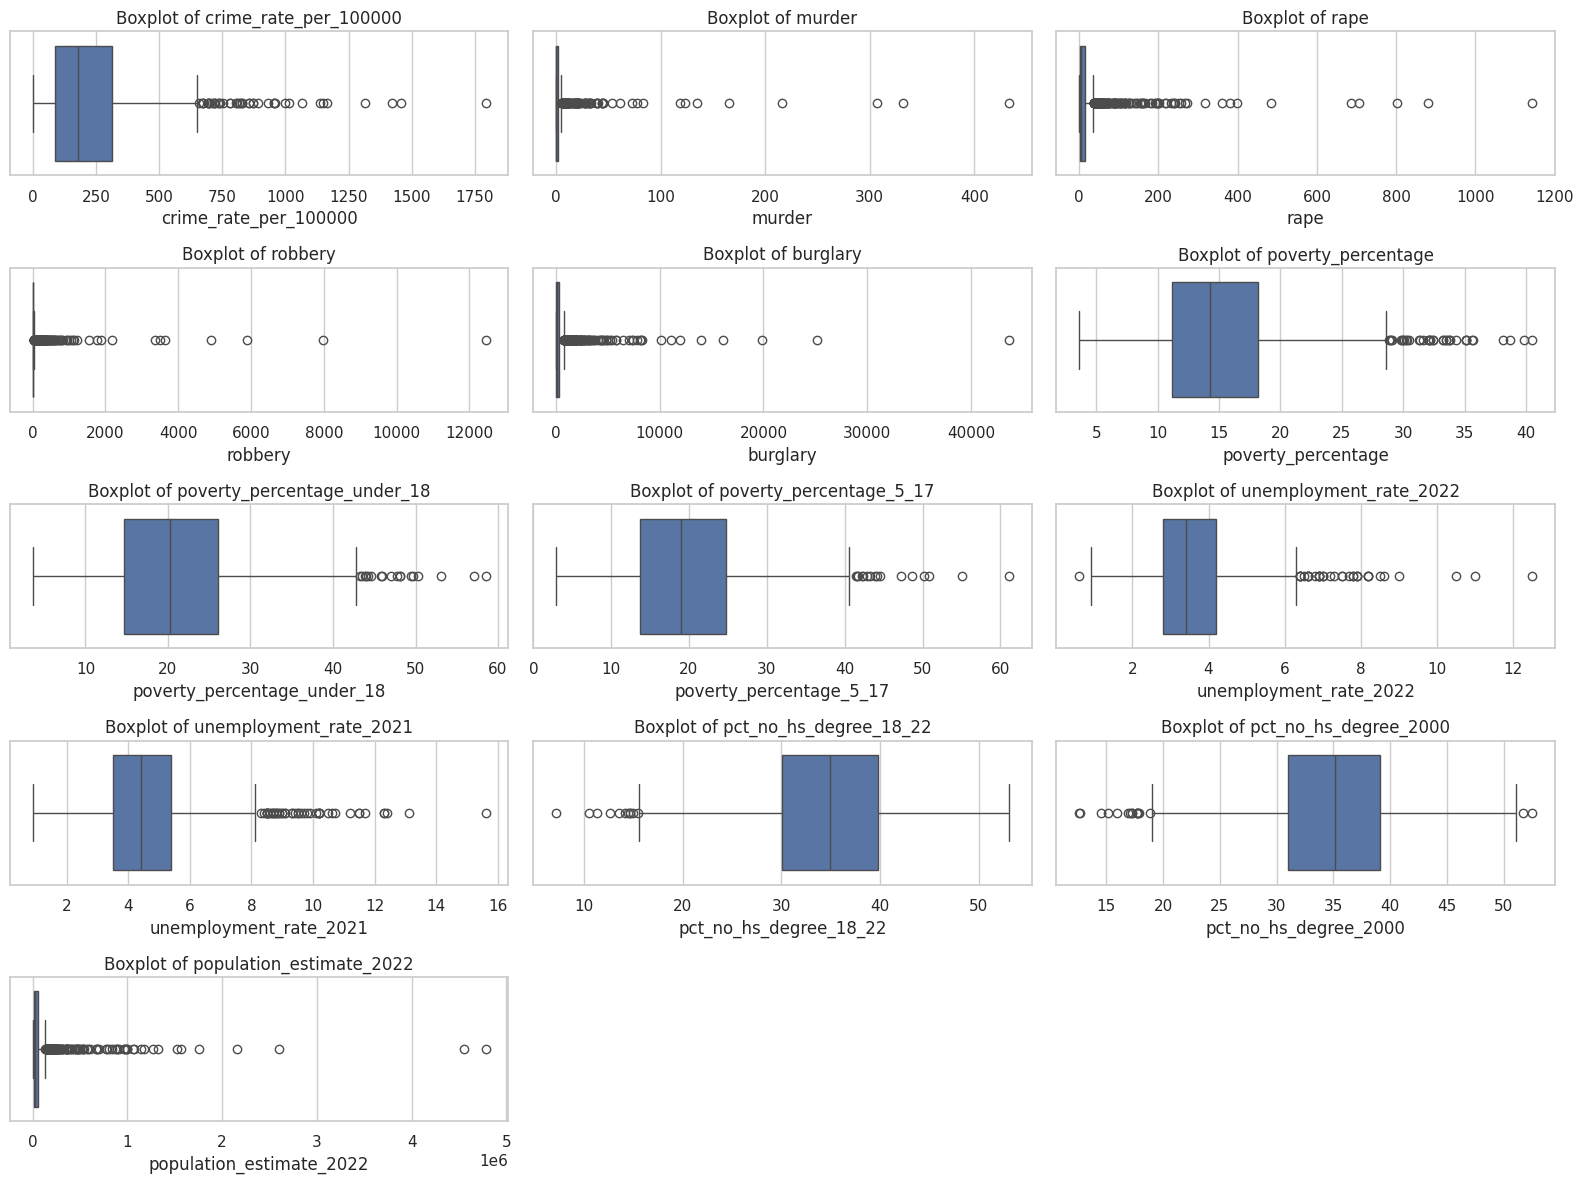

In [50]:
# Function to plot boxplots
def plot_boxplots(data, features, n_rows, n_cols):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
    axes = axes.flatten()
    for i, feature in enumerate(features):
        sns.boxplot(x=data[feature], ax=axes[i])
        axes[i].set_title(f'Boxplot of {feature}')
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

# Plot boxplots
plot_boxplots(data, features, n_rows=5, n_cols=3)

#### Pairwise Relationships

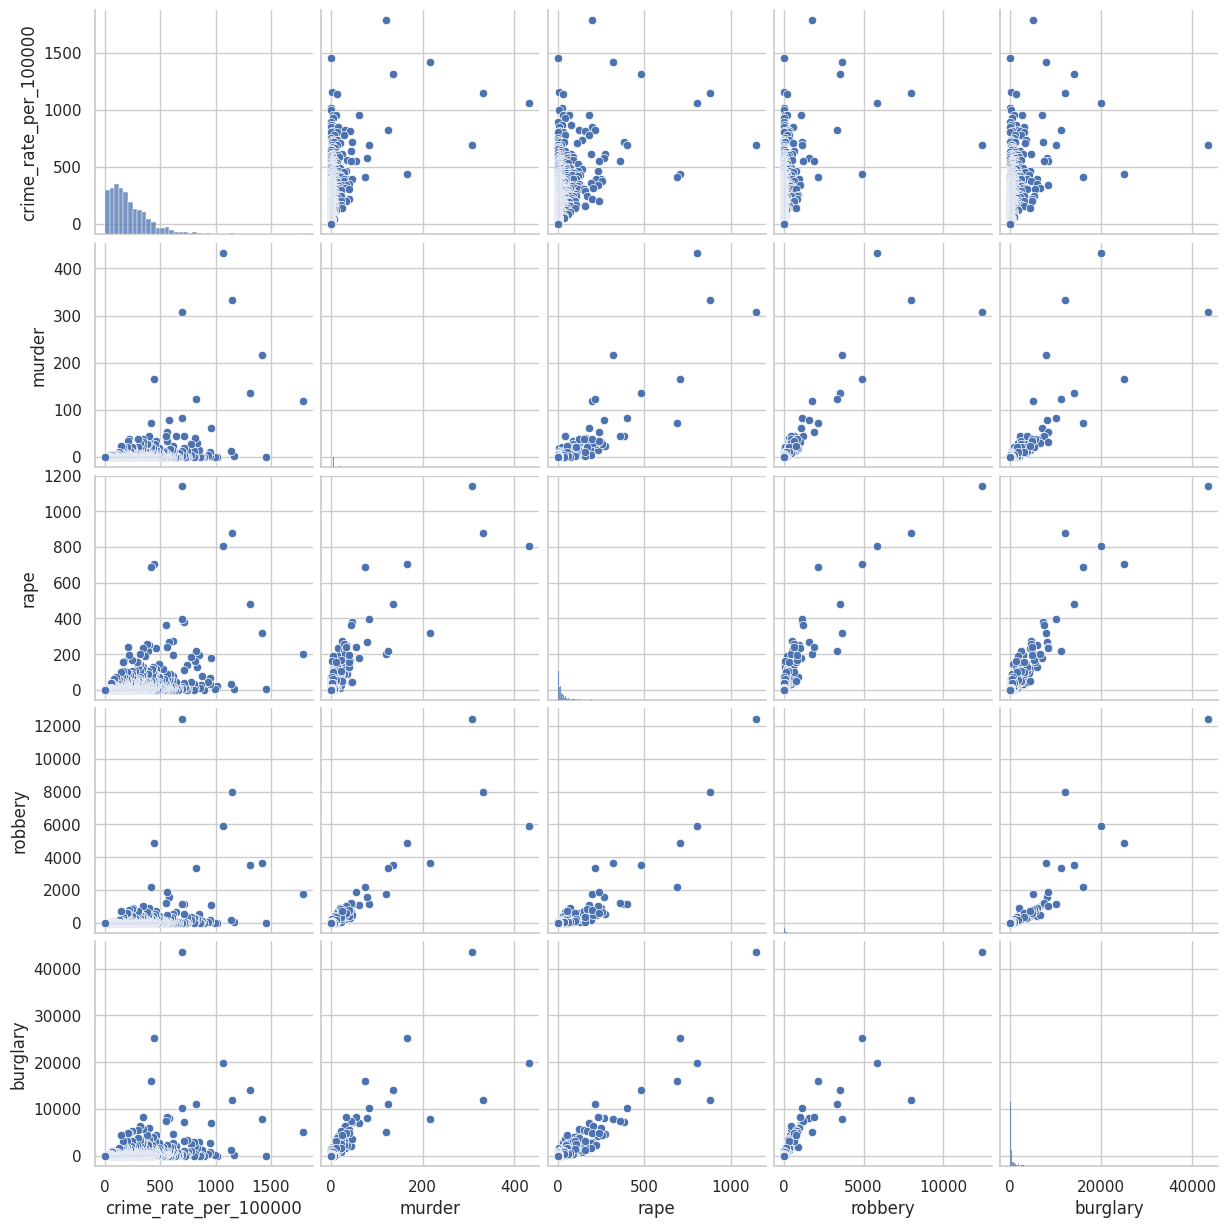

In [51]:
# Pairplot for crime-related features
sns.pairplot(data[['crime_rate_per_100000', 'murder', 'rape', 'robbery', 'burglary']])
plt.show()

# Data Cleaning and Preprocessing

####  Handle Missing Values

In [52]:
# For numerical columns, use median imputation
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])


In [53]:
# Verify no missing values remain
print("Missing Values after Imputation:")
print(data.isnull().sum())

Missing Values after Imputation:
fips_code                      0
state_name                     0
county_name                    0
crime_rate_per_100000          0
murder                         0
rape                           0
robbery                        0
burglary                       0
poverty_percentage             0
poverty_percentage_under_18    0
poverty_percentage_5_17        0
unemployment_rate_2022         0
unemployment_rate_2021         0
pct_no_hs_degree_18_22         0
pct_no_hs_degree_2000          0
population_estimate_2022       0
dtype: int64


## Feature Engineering

In [54]:
# Composite Poverty Index
data['poverty_index'] = (data['poverty_percentage'] +
                         data['poverty_percentage_under_18'] +
                         data['poverty_percentage_5_17'])

# Education Improvement
data['education_improvement'] = data['pct_no_hs_degree_2000'] - data['pct_no_hs_degree_18_22']

# Drop redundant features to avoid multicollinearity
features_to_drop = [
    'fips_code', 'state_name', 'county_name',  # Non-numeric identifiers
    'poverty_percentage', 'poverty_percentage_under_18', 'poverty_percentage_5_17',  # Components of poverty_index
    'pct_no_hs_degree_2000', 'pct_no_hs_degree_18_22',  # Components of education_improvement
    'unemployment_rate_2021'  # Less recent data
]
data = data.drop(columns=features_to_drop)

In [55]:
# Define features and target
X = data.drop(columns=['crime_rate_per_100000'])
y = data['crime_rate_per_100000']

In [56]:
# Split the data into training and testing sets BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Outliers

In [57]:
# Function to cap outliers using the 1st and 99th percentiles
def cap_outliers(df, column):
    lower_limit = df[column].quantile(0.01)
    upper_limit = df[column].quantile(0.99)
    df[column] = df[column].clip(lower=lower_limit, upper=upper_limit)
    return df

# Apply to selected features in training data only
for col in ['murder', 'rape', 'robbery', 'burglary']:
    X_train = cap_outliers(X_train, col)
    X_test = cap_outliers(X_test, col)

# Cap outliers in the target variable in training data
y_train = cap_outliers(pd.DataFrame(y_train), 'crime_rate_per_100000')
y_test = cap_outliers(pd.DataFrame(y_test), 'crime_rate_per_100000')
y_train = y_train['crime_rate_per_100000']
y_test = y_test['crime_rate_per_100000']

#####  log transformations to skewed features.

In [58]:
# Identify skewed features in training data
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
skewed_features = X_train[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
print("Skewness before transformation (Training Data):\n", skewed_features)

# Features with skewness > 1
skewed_features = skewed_features[skewed_features > 1].index.tolist()
print("Skewed Features:", skewed_features)

# Apply log1p transformation to skewed features in training data
for feature in skewed_features:
    X_train[feature] = np.log1p(X_train[feature])

# Apply same transformation to test data
for feature in skewed_features:
    X_test[feature] = np.log1p(X_test[feature])

# Also apply log1p transformation to the target variable
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

Skewness before transformation (Training Data):
 population_estimate_2022    10.695999
robbery                      6.053462
murder                       5.747284
burglary                     4.858734
rape                         4.085354
unemployment_rate_2022       1.313687
poverty_index                0.674432
education_improvement       -0.671632
dtype: float64
Skewed Features: ['population_estimate_2022', 'robbery', 'murder', 'burglary', 'rape', 'unemployment_rate_2022']


In [59]:
# Recalculate skewness after transformation
skewed_features_after = X_train[skewed_features].apply(lambda x: x.skew()).sort_values(ascending=False)
print("Skewness after transformation (Training Data):\n", skewed_features_after)

Skewness after transformation (Training Data):
 murder                      1.689915
robbery                     0.967664
rape                        0.529998
unemployment_rate_2022      0.405317
population_estimate_2022    0.320646
burglary                   -0.249061
dtype: float64


####  Feature Scaling

In [60]:
# Initialize the scaler
scaler_X = StandardScaler()

# Fit on training data
X_train_scaled = scaler_X.fit_transform(X_train)

# Apply transformation to test data
X_test_scaled = scaler_X.transform(X_test)

# Save the scaler for later use
joblib.dump(scaler_X, 'scaler_X.joblib')

['scaler_X.joblib']

VIF

In [61]:
# Calculate VIF on scaled training data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_scaled_df.values, i) for i in range(X_train_scaled_df.shape[1])]

print("VIF Scores:\n", vif_data.sort_values(by='VIF', ascending=False))

VIF Scores:
                     Feature       VIF
2                   robbery  6.857015
3                  burglary  6.088363
5  population_estimate_2022  5.569436
1                      rape  4.948741
0                    murder  3.041726
6             poverty_index  2.199143
4    unemployment_rate_2022  1.542340
7     education_improvement  1.477017


#### Feature Selection with SelectKBest

In [62]:
# Apply SelectKBest on training data
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train_scaled, y_train)

# Get scores and p-values
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector.scores_,
    'p-Value': selector.pvalues_
}).sort_values(by='Score', ascending=False)

print("Feature scores after SelectKBest:\n", feature_scores)

Feature scores after SelectKBest:
                     Feature       Score        p-Value
3                  burglary  730.904754  1.508173e-121
1                      rape  365.253656   9.668585e-70
2                   robbery  334.301750   9.817294e-65
5  population_estimate_2022  212.458420   8.066968e-44
0                    murder  190.589667   7.675283e-40
4    unemployment_rate_2022    8.919762   2.889102e-03
6             poverty_index    8.661422   3.324500e-03
7     education_improvement    6.486798   1.101524e-02


In [63]:
# Save preprocessed training data
preprocessed_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
preprocessed_train['crime_rate_per_100000'] = y_train.reset_index(drop=True)
preprocessed_train.to_csv('preprocessed_train.csv', index=False)

# Save preprocessed testing data
preprocessed_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
preprocessed_test['crime_rate_per_100000'] = y_test.reset_index(drop=True)
preprocessed_test.to_csv('preprocessed_test.csv', index=False)